В первой части будет построена модель логистической регрессии двумя способами - как нейросеть без скрытых слоев и "коробочное решение" библиотеки sklearn путем подбора оптимальных параметров через GridSearchCV

In [1]:
import tensorflow as tf
import pandas as pd
from google.colab import drive
drive.mount('/gdrive' )

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

tf.compat.v1.disable_eager_execution()

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
df_train = pd.read_csv('/fashion-mnist_train.csv')

X_train = df_train.iloc[:,1:].values
y_train = df_train.iloc[:,0].values

X_train = scaler.fit_transform(X_train)
y_train = tf.keras.utils.to_categorical(y_train, 10)

In [3]:
df_test = pd.read_csv('/gdrive/My Drive/fashion-mnist_test.csv')

X_test = df_test.iloc[:,1:].values
y_test = df_test.iloc[:,0].values

X_test = scaler.transform(X_test)
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [4]:
learning_rate = 0.1
epochs = 1000

num_input = 784
num_classes = 10

X = tf.compat.v1.placeholder('float', [None, num_input])
Y = tf.compat.v1.placeholder('float', [None, num_classes])

weights = tf.Variable(tf.random.normal([num_input, num_classes]))
biases = tf.Variable(tf.random.normal([num_classes]))


In [5]:
logits = tf.matmul(X, weights) + biases

loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(
        logits=logits, labels=Y)
                    )

optimizer = tf.compat.v1.train.GradientDescentOptimizer(
                                          learning_rate=learning_rate)
train = optimizer.minimize(loss)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

init = tf.compat.v1.global_variables_initializer()

In [6]:
train_scores = []
test_scores = []

with tf.compat.v1.Session() as sess:
    sess.run(init)

    for epoch in range(epochs):
        sess.run(train, feed_dict={X: X_train, Y: y_train})

        if epoch % 50 == 0 or epoch == (epochs - 1):
            train_accuracy = sess.run(accuracy, 
                                      feed_dict={
                                                  X: X_train,
                                                  Y: y_train
                                                }
                                      )
            
            test_accuracy = sess.run(accuracy, 
                                      feed_dict={
                                                  X: X_test,
                                                  Y: y_test
                                                }
                                      )
            train_scores.append((epoch, train_accuracy))
            test_scores.append((epoch, test_accuracy))
            

    

Изменение метрики accuracy на тренировочных и тестовых данных в процессе обучения модели, созданной вручную. Итоговый показатель - 0,77.

In [7]:
train_scores

[(0, 0.14113334),
 (50, 0.5362333),
 (100, 0.61865),
 (150, 0.6547833),
 (200, 0.67793334),
 (250, 0.6952),
 (300, 0.7076333),
 (350, 0.71751666),
 (400, 0.72495),
 (450, 0.7306833),
 (500, 0.736),
 (550, 0.74085),
 (600, 0.7453333),
 (650, 0.74908334),
 (700, 0.75215),
 (750, 0.7547333),
 (800, 0.75761664),
 (850, 0.7596833),
 (900, 0.76156664),
 (950, 0.76351666),
 (999, 0.76533335)]

In [8]:
test_scores

[(0, 0.1454),
 (50, 0.5428),
 (100, 0.623),
 (150, 0.6601),
 (200, 0.6822),
 (250, 0.6971),
 (300, 0.7086),
 (350, 0.7192),
 (400, 0.726),
 (450, 0.7316),
 (500, 0.737),
 (550, 0.7425),
 (600, 0.7473),
 (650, 0.7501),
 (700, 0.7535),
 (750, 0.7569),
 (800, 0.7599),
 (850, 0.762),
 (900, 0.7632),
 (950, 0.7652),
 (999, 0.7676)]

In [9]:
from sklearn.linear_model import LogisticRegression

In [ ]:
clf = LogisticRegression()

y_train = df_train.iloc[:,0].values
y_test = df_test.iloc[:,0].values

clf.fit(X_train, y_train)


Подсчет метрики "коробочной" модели с дефолтными параметрами

In [23]:
clf.score(X_train, y_train), clf.score(X_test, y_test)

(0.8766166666666667, 0.8521)

Подбор оптимальных параметров для наилучшего показателя accuracy

In [ ]:
from sklearn.model_selection import GridSearchCV

grid_clf = GridSearchCV(clf, param_grid = {'C': [0.1, 0.5, 1, 10],
                                           'penalty': ['l1', 'l2', 'elasticnet'],
                                           'solver': ['lbfgs', 'saga']},
                        cv=3
                        )
grid_clf.fit(X_train, y_train)

In [28]:
grid_clf.best_params_, grid_clf.best_score_

({'C': 0.5, 'penalty': 'l2', 'solver': 'saga'}, 0.85315)

In [ ]:
clf_best = LogisticRegression(C=0.5, penalty='l2', solver='saga')
clf_best.fit(X_train, y_train)

Подсчет метрики с оптимальными параметрами - на тестовых данных показатель немного улучшился

In [31]:
clf_best.score(X_train, y_train), clf_best.score(X_test, y_test)

(0.8654, 0.8579)

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

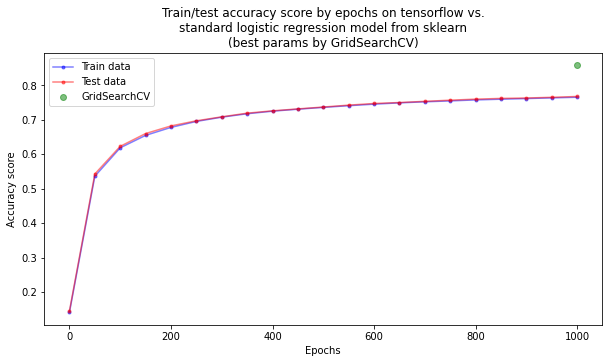

In [71]:
plt.figure(figsize=(10,5))
plt.plot([i[0] for i in train_scores], [i[1] for i in train_scores],
         '-o', c='blue', label='Train data', alpha=0.5, markersize=3)
plt.plot([i[0] for i in test_scores], [i[1] for i in test_scores],
         '-o', c='red', label='Test data', alpha=0.5, markersize=3)

plt.scatter(999, clf_best.score(X_test, y_test), c='green',
            alpha=0.5, label='GridSearchCV')

plt.xlabel('Epochs')
plt.ylabel('Accuracy score')
plt.title('Train/test accuracy score by epochs on tensorflow vs.\nstandard logistic regression model from sklearn\n(best params by GridSearchCV)')
plt.legend();

График изменения метрики на тестовых и тренировочных данных по мере обучения "ручной" модели и точкой обозначена валидационная accuracy "коробочной" модели с оптимальными параметрами. Итоговые значения на тестовых данных - 0,86 и 0,77 в пользу "коробочного" решения.